In [544]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import math
from skimage.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import time
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# set the max columns to none
pd.set_option('display.max_columns', None)

# 1. Load data

In [545]:
df = pd.read_csv('../datasets/complete_data/df.csv')
df

,start MTU (UTC),Day-ahead Price [EUR/MWh] BZN|NO1,Day-ahead Price [EUR/MWh] BZN|NO3,Day-ahead Price [EUR/MWh] BZN|NO5,Day-ahead Price [EUR/MWh] BZN|SE3,Actual Total Load [MW] - BZN|NO5,Hydro Run-of-river and poundage - BZN|NO1,Hydro Water Reservoir - BZN|NO1,Wind Onshore - BZN|NO1,Hydro Pumped Storage Aggregated- BZN|NO2,Hydro Run-of-river and poundage - BZN|NO2,Hydro Water Reservoir - BZN|NO2,Waste - BZN|NO2,Wind Onshore - BZN|NO2,Hydro Pumped Storage Aggregated- BZN|NO3,Hydro Run-of-river and poundage - BZN|NO3,Hydro Water Reservoir - BZN|NO3,Other renewable - BZN|NO3,Wind Onshore - BZN|NO3,Fossil Gas - BZN|NO5,Hydro Pumped Storage Aggregated- BZN|NO5,Hydro Run-of-river and poundage - BZN|NO5,Waste - BZN|NO5,Hydro Water Reservoir - BZN|SE3,Nuclear - BZN|SE3,Solar - BZN|SE3,Wind Onshore - BZN|SE3,CBF BZN|NO2 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO2 [MW],CBF BZN|NO3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO3 [MW],CBF BZN|NO5 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO5 [MW],CBF BZN|SE3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|SE3 [MW],Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|NO3,Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|SE3
0,2022-01-01 00:00:00,129.30,41.33,129.30,41.33,1991.000000,878.0,321.0,172.0,1.0,629.0,2153.333333,5.0,244.0,40.0,389.0,2166.0,12.0,219.0,82.0,66.0,227.0,19.0,818.0,5842.0,0.0,999.0,1242.0,0.0,371.0,0.0,594.0,0.0,1065.0,0.0,5688093.0,1656000.0
1,2022-01-01 01:00:00,132.08,42.18,132.08,42.18,1992.666667,897.0,330.0,151.0,1.0,627.0,2012.000000,4.0,115.0,42.0,390.0,2187.0,12.0,170.0,82.0,66.0,216.0,20.0,818.0,5839.0,0.0,958.0,1222.0,0.0,383.0,0.0,676.0,0.0,927.0,0.0,5688093.0,1656000.0
2,2022-01-01 02:00:00,111.44,44.37,111.44,44.37,1994.333333,885.0,275.0,160.0,1.0,624.0,1999.555556,4.0,55.0,45.0,405.0,2183.0,12.0,126.0,82.0,65.0,215.0,20.0,838.0,5839.0,0.0,888.0,1679.0,0.0,362.0,0.0,436.0,0.0,748.0,0.0,5688093.0,1656000.0
3,2022-01-01 03:00:00,112.35,37.67,112.35,37.67,1996.000000,890.0,269.0,148.0,1.0,624.0,1987.111111,4.0,61.0,34.0,393.0,2076.0,12.0,81.0,82.0,65.0,209.0,20.0,842.0,5840.0,0.0,788.0,1668.0,0.0,324.0,0.0,345.0,0.0,918.0,0.0,5688093.0,1656000.0
4,2022-01-01 04:00:00,113.90,39.70,113.90,39.70,1985.500000,892.0,300.0,147.0,1.0,605.0,1974.666667,4.0,88.0,38.0,398.0,2098.0,11.0,45.0,82.0,65.0,210.0,19.0,841.0,5839.0,0.0,734.0,1697.0,0.0,339.0,0.0,412.0,0.0,826.0,0.0,5688093.0,1656000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,123.61,23.82,123.61,11.57,2128.000000,992.0,621.0,74.0,1.0,823.0,2399.000000,13.0,443.0,34.0,187.0,987.0,23.0,1576.0,7.0,24.0,148.0,14.0,627.0,5796.0,0.0,1499.0,621.0,0.0,146.0,0.0,43.0,0.0,2083.0,0.0,5038234.0,1579000.0
8756,2022-12-31 20:00:00,121.09,23.93,121.09,14.89,2089.000000,980.0,610.0,70.5,1.0,828.0,2265.000000,13.0,443.0,35.0,187.0,997.0,23.0,1548.0,7.0,25.0,135.0,14.0,573.0,5797.0,0.0,1282.0,595.0,0.0,124.0,0.0,24.0,0.0,2097.0,0.0,5038234.0,1579000.0
8757,2022-12-31 21:00:00,120.00,23.75,120.00,9.94,2037.000000,980.0,588.0,67.0,1.0,814.0,2265.000000,13.0,443.0,35.0,182.0,868.0,23.0,1525.0,7.0,25.0,127.0,14.0,544.0,5797.0,0.0,1168.0,608.0,0.0,91.0,0.0,41.0,0.0,2007.0,0.0,5038234.0,1579000.0
8758,2022-12-31 22:00:00,119.98,23.56,119.98,4.84,1991.000000,989.0,585.0,69.0,0.0,814.0,2098.000000,13.0,443.0,35.0,183.0,814.0,23.0,1498.0,7.0,25.0,137.0,14.0,539.0,5796.0,0.0,1033.0,504.0,0.0,90.0,0.0,0.0,29.0,2119.0,0.0,5038234.0,1579000.0


In [546]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 37 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   start MTU (UTC)                                                                8760 non-null   object 
 1   Day-ahead Price [EUR/MWh] BZN|NO1                                              8760 non-null   float64
 2   Day-ahead Price [EUR/MWh] BZN|NO3                                              8760 non-null   float64
 3   Day-ahead Price [EUR/MWh] BZN|NO5                                              8760 non-null   float64
 4   Day-ahead Price [EUR/MWh] BZN|SE3                                              8760 non-null   float64
 5   Actual Total Load [MW] - BZN|NO5                                               8760 non-null   float64
 6   Hydro Run-of-river and p

# 2. Preprocessing

#### 2.1 Indexing

In [547]:
df = df.set_index('start MTU (UTC)')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.index

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', name='start MTU (UTC)', length=8760, freq=None)

#### 2.2 Plotting 'Day-ahead Price BZN|NO1'

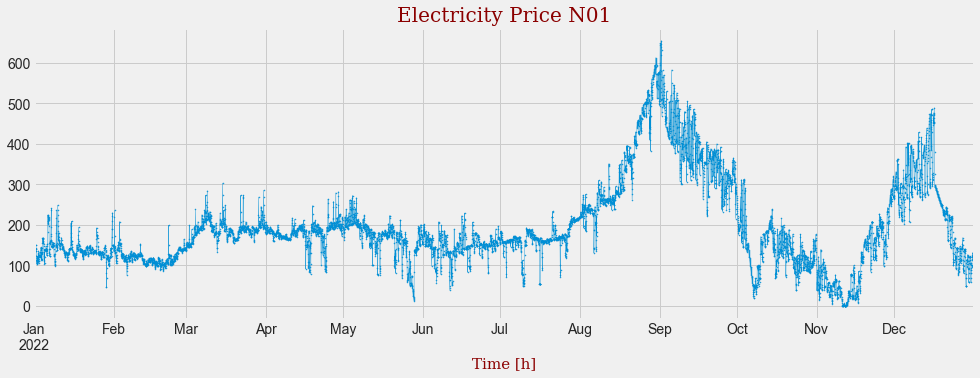

In [548]:
target_column = df['Day-ahead Price [EUR/MWh] BZN|NO1']
target_column_df =  pd.DataFrame(target_column)
target_column.plot( figsize=(15, 5), color=color_pal[0], lw=0.4, marker="." , markersize=1)

font1 = {'family':'serif','color':'darkred','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
plt.title("Electricity Price N01", fontdict = font1)
plt.xlabel("Time [h]", fontdict = font2)
plt.show()

<AxesSubplot:ylabel='Frequency'>

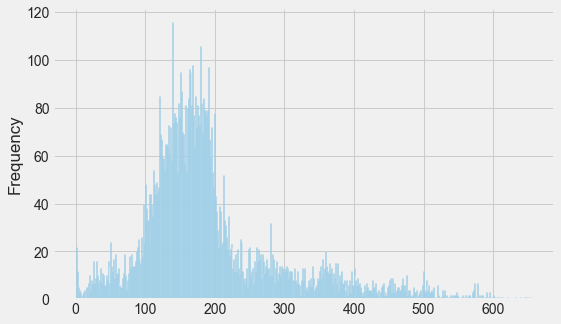

In [549]:
df['Day-ahead Price [EUR/MWh] BZN|NO1'].plot(kind='hist',figsize=(8, 5), bins=500)

In [550]:
df.query( '`Day-ahead Price [EUR/MWh] BZN|NO1` > 100.0 ')

,Day-ahead Price [EUR/MWh] BZN|NO1,Day-ahead Price [EUR/MWh] BZN|NO3,Day-ahead Price [EUR/MWh] BZN|NO5,Day-ahead Price [EUR/MWh] BZN|SE3,Actual Total Load [MW] - BZN|NO5,Hydro Run-of-river and poundage - BZN|NO1,Hydro Water Reservoir - BZN|NO1,Wind Onshore - BZN|NO1,Hydro Pumped Storage Aggregated- BZN|NO2,Hydro Run-of-river and poundage - BZN|NO2,Hydro Water Reservoir - BZN|NO2,Waste - BZN|NO2,Wind Onshore - BZN|NO2,Hydro Pumped Storage Aggregated- BZN|NO3,Hydro Run-of-river and poundage - BZN|NO3,Hydro Water Reservoir - BZN|NO3,Other renewable - BZN|NO3,Wind Onshore - BZN|NO3,Fossil Gas - BZN|NO5,Hydro Pumped Storage Aggregated- BZN|NO5,Hydro Run-of-river and poundage - BZN|NO5,Waste - BZN|NO5,Hydro Water Reservoir - BZN|SE3,Nuclear - BZN|SE3,Solar - BZN|SE3,Wind Onshore - BZN|SE3,CBF BZN|NO2 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO2 [MW],CBF BZN|NO3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO3 [MW],CBF BZN|NO5 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO5 [MW],CBF BZN|SE3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|SE3 [MW],Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|NO3,Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|SE3
start MTU (UTC),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,129.30,41.33,129.30,41.33,1991.000000,878.0,321.0,172.0,1.0,629.0,2153.333333,5.0,244.0,40.0,389.0,2166.0,12.0,219.0,82.0,66.0,227.0,19.0,818.0,5842.0,0.0,999.0,1242.0,0.0,371.0,0.0,594.0,0.0,1065.0,0.0,5688093.0,1656000.0
2022-01-01 01:00:00,132.08,42.18,132.08,42.18,1992.666667,897.0,330.0,151.0,1.0,627.0,2012.000000,4.0,115.0,42.0,390.0,2187.0,12.0,170.0,82.0,66.0,216.0,20.0,818.0,5839.0,0.0,958.0,1222.0,0.0,383.0,0.0,676.0,0.0,927.0,0.0,5688093.0,1656000.0
2022-01-01 02:00:00,111.44,44.37,111.44,44.37,1994.333333,885.0,275.0,160.0,1.0,624.0,1999.555556,4.0,55.0,45.0,405.0,2183.0,12.0,126.0,82.0,65.0,215.0,20.0,838.0,5839.0,0.0,888.0,1679.0,0.0,362.0,0.0,436.0,0.0,748.0,0.0,5688093.0,1656000.0
2022-01-01 03:00:00,112.35,37.67,112.35,37.67,1996.000000,890.0,269.0,148.0,1.0,624.0,1987.111111,4.0,61.0,34.0,393.0,2076.0,12.0,81.0,82.0,65.0,209.0,20.0,842.0,5840.0,0.0,788.0,1668.0,0.0,324.0,0.0,345.0,0.0,918.0,0.0,5688093.0,1656000.0
2022-01-01 04:00:00,113.90,39.70,113.90,39.70,1985.500000,892.0,300.0,147.0,1.0,605.0,1974.666667,4.0,88.0,38.0,398.0,2098.0,11.0,45.0,82.0,65.0,210.0,19.0,841.0,5839.0,0.0,734.0,1697.0,0.0,339.0,0.0,412.0,0.0,826.0,0.0,5688093.0,1656000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,123.61,23.82,123.61,11.57,2128.000000,992.0,621.0,74.0,1.0,823.0,2399.000000,13.0,443.0,34.0,187.0,987.0,23.0,1576.0,7.0,24.0,148.0,14.0,627.0,5796.0,0.0,1499.0,621.0,0.0,146.0,0.0,43.0,0.0,2083.0,0.0,5038234.0,1579000.0
2022-12-31 20:00:00,121.09,23.93,121.09,14.89,2089.000000,980.0,610.0,70.5,1.0,828.0,2265.000000,13.0,443.0,35.0,187.0,997.0,23.0,1548.0,7.0,25.0,135.0,14.0,573.0,5797.0,0.0,1282.0,595.0,0.0,124.0,0.0,24.0,0.0,2097.0,0.0,5038234.0,1579000.0
2022-12-31 21:00:00,120.00,23.75,120.00,9.94,2037.000000,980.0,588.0,67.0,1.0,814.0,2265.000000,13.0,443.0,35.0,182.0,868.0,23.0,1525.0,7.0,25.0,127.0,14.0,544.0,5797.0,0.0,1168.0,608.0,0.0,91.0,0.0,41.0,0.0,2007.0,0.0,5038234.0,1579000.0


#### 2.3 Dropping features

#### 2.4 Normalization and scaling

#### 2.5 PCA

#### 2.6 Feature engineering

###### 2.6.1 Create hour feature

In [551]:
def create_features (df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df
create_features(df)
df

,Day-ahead Price [EUR/MWh] BZN|NO1,Day-ahead Price [EUR/MWh] BZN|NO3,Day-ahead Price [EUR/MWh] BZN|NO5,Day-ahead Price [EUR/MWh] BZN|SE3,Actual Total Load [MW] - BZN|NO5,Hydro Run-of-river and poundage - BZN|NO1,Hydro Water Reservoir - BZN|NO1,Wind Onshore - BZN|NO1,Hydro Pumped Storage Aggregated- BZN|NO2,Hydro Run-of-river and poundage - BZN|NO2,Hydro Water Reservoir - BZN|NO2,Waste - BZN|NO2,Wind Onshore - BZN|NO2,Hydro Pumped Storage Aggregated- BZN|NO3,Hydro Run-of-river and poundage - BZN|NO3,Hydro Water Reservoir - BZN|NO3,Other renewable - BZN|NO3,Wind Onshore - BZN|NO3,Fossil Gas - BZN|NO5,Hydro Pumped Storage Aggregated- BZN|NO5,Hydro Run-of-river and poundage - BZN|NO5,Waste - BZN|NO5,Hydro Water Reservoir - BZN|SE3,Nuclear - BZN|SE3,Solar - BZN|SE3,Wind Onshore - BZN|SE3,CBF BZN|NO2 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO2 [MW],CBF BZN|NO3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO3 [MW],CBF BZN|NO5 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO5 [MW],CBF BZN|SE3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|SE3 [MW],Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|NO3,Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|SE3,hour,dayofweek
start MTU (UTC),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,129.30,41.33,129.30,41.33,1991.000000,878.0,321.0,172.0,1.0,629.0,2153.333333,5.0,244.0,40.0,389.0,2166.0,12.0,219.0,82.0,66.0,227.0,19.0,818.0,5842.0,0.0,999.0,1242.0,0.0,371.0,0.0,594.0,0.0,1065.0,0.0,5688093.0,1656000.0,0,5
2022-01-01 01:00:00,132.08,42.18,132.08,42.18,1992.666667,897.0,330.0,151.0,1.0,627.0,2012.000000,4.0,115.0,42.0,390.0,2187.0,12.0,170.0,82.0,66.0,216.0,20.0,818.0,5839.0,0.0,958.0,1222.0,0.0,383.0,0.0,676.0,0.0,927.0,0.0,5688093.0,1656000.0,1,5
2022-01-01 02:00:00,111.44,44.37,111.44,44.37,1994.333333,885.0,275.0,160.0,1.0,624.0,1999.555556,4.0,55.0,45.0,405.0,2183.0,12.0,126.0,82.0,65.0,215.0,20.0,838.0,5839.0,0.0,888.0,1679.0,0.0,362.0,0.0,436.0,0.0,748.0,0.0,5688093.0,1656000.0,2,5
2022-01-01 03:00:00,112.35,37.67,112.35,37.67,1996.000000,890.0,269.0,148.0,1.0,624.0,1987.111111,4.0,61.0,34.0,393.0,2076.0,12.0,81.0,82.0,65.0,209.0,20.0,842.0,5840.0,0.0,788.0,1668.0,0.0,324.0,0.0,345.0,0.0,918.0,0.0,5688093.0,1656000.0,3,5
2022-01-01 04:00:00,113.90,39.70,113.90,39.70,1985.500000,892.0,300.0,147.0,1.0,605.0,1974.666667,4.0,88.0,38.0,398.0,2098.0,11.0,45.0,82.0,65.0,210.0,19.0,841.0,5839.0,0.0,734.0,1697.0,0.0,339.0,0.0,412.0,0.0,826.0,0.0,5688093.0,1656000.0,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,123.61,23.82,123.61,11.57,2128.000000,992.0,621.0,74.0,1.0,823.0,2399.000000,13.0,443.0,34.0,187.0,987.0,23.0,1576.0,7.0,24.0,148.0,14.0,627.0,5796.0,0.0,1499.0,621.0,0.0,146.0,0.0,43.0,0.0,2083.0,0.0,5038234.0,1579000.0,19,5
2022-12-31 20:00:00,121.09,23.93,121.09,14.89,2089.000000,980.0,610.0,70.5,1.0,828.0,2265.000000,13.0,443.0,35.0,187.0,997.0,23.0,1548.0,7.0,25.0,135.0,14.0,573.0,5797.0,0.0,1282.0,595.0,0.0,124.0,0.0,24.0,0.0,2097.0,0.0,5038234.0,1579000.0,20,5
2022-12-31 21:00:00,120.00,23.75,120.00,9.94,2037.000000,980.0,588.0,67.0,1.0,814.0,2265.000000,13.0,443.0,35.0,182.0,868.0,23.0,1525.0,7.0,25.0,127.0,14.0,544.0,5797.0,0.0,1168.0,608.0,0.0,91.0,0.0,41.0,0.0,2007.0,0.0,5038234.0,1579000.0,21,5


###### 2.6.2 Create total import feature

###### 2.6.3 Create total export feature

###### 2.6.4 Create total load feature

#### 2.7  Visualize target and hour feature's relationship

<function matplotlib.pyplot.show(close=None, block=None)>

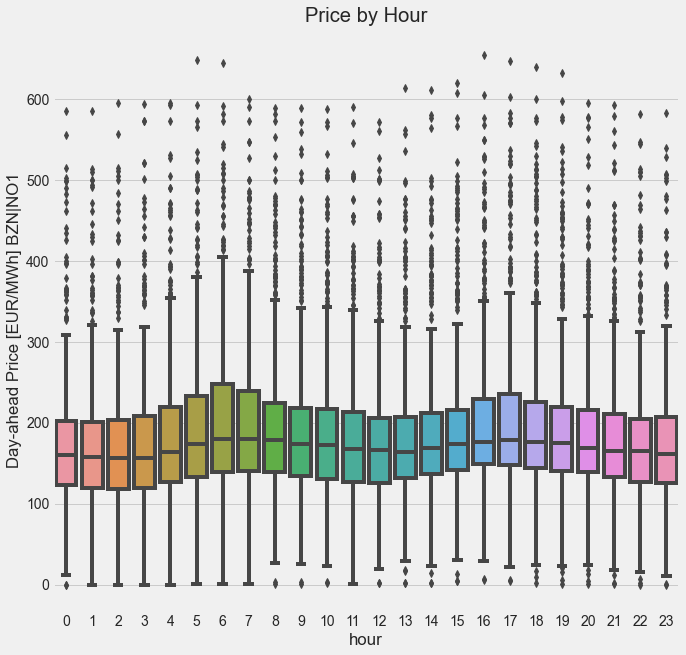

In [552]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=df, x='hour', y='Day-ahead Price [EUR/MWh] BZN|NO1')
ax.set_title('Price by Hour')
plt.show

# 3. Time series cross validation

### Removing symbols from feature names

In [553]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<', '>'))) else col for col in df.columns.values]

In [554]:
TARGET = 'Day-ahead Price _EUR/MWh_ BZN|NO1'

FEATURES = [
    'Day-ahead Price _EUR/MWh_ BZN|NO3',
    'Day-ahead Price _EUR/MWh_ BZN|SE3', 'Actual Total Load _MW_ - BZN|NO5',
    'Hydro Run-of-river and poundage - BZN|NO1',
    'Hydro Water Reservoir - BZN|NO1', 'Wind Onshore - BZN|NO1',
    'Hydro Pumped Storage Aggregated- BZN|NO2',
    'Hydro Run-of-river and poundage - BZN|NO2',
    'Hydro Water Reservoir - BZN|NO2',
    'Waste - BZN|NO2',
    'Wind Onshore - BZN|NO2', 'Hydro Pumped Storage Aggregated- BZN|NO3',
    'Hydro Run-of-river and poundage - BZN|NO3',
    'Hydro Water Reservoir - BZN|NO3', 'Other renewable - BZN|NO3',
    'Wind Onshore - BZN|NO3', 'Fossil Gas - BZN|NO5',
    'Hydro Pumped Storage Aggregated- BZN|NO5',
    'Hydro Run-of-river and poundage - BZN|NO5', 'Waste - BZN|NO5',
    'Hydro Water Reservoir - BZN|SE3', 'Nuclear - BZN|SE3',
    'Solar - BZN|SE3', 'Wind Onshore - BZN|SE3',
    'CBF BZN|NO2 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO2 _MW_',
    'CBF BZN|NO3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO3 _MW_',
    'CBF BZN|NO5 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO5 _MW_',
    'CBF BZN|SE3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|SE3 _MW_',
    'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3',
    'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3',
    'hour']

## 2. Create lag features
 We have to keep in mind that the lag feature can not be longer than our forecastinghorizon(24h).

In [555]:
"""
# df_limited = df.loc[ '2022-12-21' : '2022-12-31']
# "2022-12-21 00:00:00 to 2022-12-31 23:00:00"

def add_lags(df):
    # Creating a dictionary of target feature to
    target_map = df[TARGET].to_dict()
    # subtract 24 our from every hourly timestamp(our indexes) we have, and map() the target feature onto our df
    df['lag1'] = (df.index - pd.Timedelta('1 day')).map(target_map)
    return df

add_lags(df)
df.dropna()

"""

'\n# df_limited = df.loc[ \'2022-12-21\' : \'2022-12-31\']\n# "2022-12-21 00:00:00 to 2022-12-31 23:00:00"\n\ndef add_lags(df):\n    # Creating a dictionary of target feature to\n    target_map = df[TARGET].to_dict()\n    # subtract 24 our from every hourly timestamp(our indexes) we have, and map() the target feature onto our df\n    df[\'lag1\'] = (df.index - pd.Timedelta(\'1 day\')).map(target_map)\n    return df\n\nadd_lags(df)\ndf.dropna()\n\n'

In [556]:
# Create 24-hour lagged features
for i in range(1, 24):
    for col in ['Day-ahead Price _EUR/MWh_ BZN|NO3',
                'Day-ahead Price _EUR/MWh_ BZN|SE3', 'Actual Total Load _MW_ - BZN|NO5',
                'Hydro Run-of-river and poundage - BZN|NO1',
                'Hydro Water Reservoir - BZN|NO1', 'Wind Onshore - BZN|NO1',
                'Hydro Pumped Storage Aggregated- BZN|NO2',
                'Hydro Run-of-river and poundage - BZN|NO2',
                'Hydro Water Reservoir - BZN|NO2', 'Waste - BZN|NO2',
                'Wind Onshore - BZN|NO2', 'Hydro Pumped Storage Aggregated- BZN|NO3',
                'Hydro Run-of-river and poundage - BZN|NO3',
                'Hydro Water Reservoir - BZN|NO3', 'Other renewable - BZN|NO3',
                'Wind Onshore - BZN|NO3', 'Fossil Gas - BZN|NO5',
                'Hydro Pumped Storage Aggregated- BZN|NO5',
                'Hydro Run-of-river and poundage - BZN|NO5', 'Waste - BZN|NO5',
                'Hydro Water Reservoir - BZN|SE3', 'Nuclear - BZN|SE3',
                'Solar - BZN|SE3', 'Wind Onshore - BZN|SE3',
                'CBF BZN|NO2 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO2 _MW_',
                'CBF BZN|NO3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO3 _MW_',
                'CBF BZN|NO5 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO5 _MW_',
                'CBF BZN|SE3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|SE3 _MW_',
                'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3',
                'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3']:

        df[col+f'_lag{i}'] = df[col].shift(i)



# Drop any rows with missing values
df.dropna(inplace=True)
df

C:\Users\Isak\AppData\Local\Temp\ipykernel_40600\1210643005.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col+f'_lag{i}'] = df[col].shift(i)
C:\Users\Isak\AppData\Local\Temp\ipykernel_40600\1210643005.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col+f'_lag{i}'] = df[col].shift(i)
C:\Users\Isak\AppData\Local\Temp\ipykernel_40600\1210643005.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

Day-ahead Price _EUR/MWh_ BZN|NO1  \
start MTU (UTC)                                          
2022-01-01 23:00:00                             113.56   
2022-01-02 00:00:00                             111.66   
2022-01-02 01:00:00                             106.53   
2022-01-02 02:00:00                             104.50   
2022-01-02 03:00:00                             104.06   
...                                                ...   
2022-12-31 19:00:00                             123.61   
2022-12-31 20:00:00                             121.09   
2022-12-31 21:00:00                             120.00   
2022-12-31 22:00:00                             119.98   
2022-12-31 23:00:00                             119.32   

                     Day-ahead Price _EUR/MWh_ BZN|NO3  \
start MTU (UTC)                                          
2022-01-01 23:00:00                              32.03   
2022-01-02 00:00:00                              31.78   
2022-01-02 01:00:00                              31.80   
2022-01-02 02:00:00                              31.89   
2022-01-02 03:00:00                              29.56   
...                                                ...   
2022-12-31 19:00:00                              23.82   
2022-12-31 20:00:00                              23.93   
2022-12-31 21:00:00                              23.75   
2022-12-31 22:00:00                              23.56   
2022-12-31 23:00:00                              23.35   

                     Day-ahead Price _EUR/MWh_ BZN|NO5  \
start MTU (UTC)                                          
2022-01-01 23:00:00                             113.56   
2022-01-02 00:00:00                             111.66   
2022-01-02 01:00:00                             106.53   
2022-01-02 02:00:00                             104.50   
2022-01-02 03:00:00                             104.06   
...                                                ...   
2022-12-31 19:00:00                             123.61   
2022-12-31 20:00:00                             121.09   
2022-12-31 21:00:00                             120.00   
2022-12-31 22:00:00                             119.98   
2022-12-31 23:00:00                             119.32   

                     Day-ahead Price _EUR/MWh_ BZN|SE3  \
start MTU (UTC)                                          
2022-01-01 23:00:00                              34.73   
2022-01-02 00:00:00                              34.39   
2022-01-02 01:00:00                              34.36   
2022-01-02 02:00:00                              34.10   
2022-01-02 03:00:00                              29.56   
...                                                ...   
2022-12-31 19:00:00                              11.57   
2022-12-31 20:00:00                              14.89   
2022-12-31 21:00:00                               9.94   
2022-12-31 22:00:00                               4.84   
2022-12-31 23:00:00                               2.01   

                     Actual Total Load _MW_ - BZN|NO5  \
start MTU (UTC)                                         
2022-01-01 23:00:00                       2000.909091   
2022-01-02 00:00:00                       1997.363636   
2022-01-02 01:00:00                       1993.818182   
2022-01-02 02:00:00                       1990.272727   
2022-01-02 03:00:00                       1986.727273   
...                                               ...   
2022-12-31 19:00:00                       2128.000000   
2022-12-31 20:00:00                       2089.000000   
2022-12-31 21:00:00                       2037.000000   
2022-12-31 22:00:00                       1991.000000   
2022-12-31 23:00:00                       2009.000000   

                     Hydro Run-of-river and poundage - BZN|NO1  \
start MTU (UTC)                                                  
2022-01-01 23:00:00                                      890.0   
2022-01-02 00:00:00                                      892.

In [557]:
"""
# Define the number of hours to lag your features
num_hours = 24

# Shift your other features back by num_hours
for col in ['Day-ahead Price _EUR/MWh_ BZN|NO3',
            'Day-ahead Price _EUR/MWh_ BZN|SE3', 'Actual Total Load _MW_ - BZN|NO5',
            'Hydro Run-of-river and poundage - BZN|NO1',
            'Hydro Water Reservoir - BZN|NO1', 'Wind Onshore - BZN|NO1',
            'Hydro Pumped Storage Aggregated- BZN|NO2',
            'Hydro Run-of-river and poundage - BZN|NO2',
            'Hydro Water Reservoir - BZN|NO2', 'Waste - BZN|NO2',
            'Wind Onshore - BZN|NO2', 'Hydro Pumped Storage Aggregated- BZN|NO3',
            'Hydro Run-of-river and poundage - BZN|NO3',
            'Hydro Water Reservoir - BZN|NO3', 'Other renewable - BZN|NO3',
            'Wind Onshore - BZN|NO3', 'Fossil Gas - BZN|NO5',
            'Hydro Pumped Storage Aggregated- BZN|NO5',
            'Hydro Run-of-river and poundage - BZN|NO5', 'Waste - BZN|NO5',
            'Hydro Water Reservoir - BZN|SE3', 'Nuclear - BZN|SE3',
            'Solar - BZN|SE3', 'Wind Onshore - BZN|SE3',
            'CBF BZN|NO2 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO2 _MW_',
            'CBF BZN|NO3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO3 _MW_',
            'CBF BZN|NO5 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO5 _MW_',
            'CBF BZN|SE3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|SE3 _MW_',
            'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3',
            'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3']:
    df[col+'_lag'] = df[col].shift(num_hours)
df
"""

"\n# Define the number of hours to lag your features\nnum_hours = 24\n\n# Shift your other features back by num_hours\nfor col in ['Day-ahead Price _EUR/MWh_ BZN|NO3',\n            'Day-ahead Price _EUR/MWh_ BZN|SE3', 'Actual Total Load _MW_ - BZN|NO5',\n            'Hydro Run-of-river and poundage - BZN|NO1',\n            'Hydro Water Reservoir - BZN|NO1', 'Wind Onshore - BZN|NO1',\n            'Hydro Pumped Storage Aggregated- BZN|NO2',\n            'Hydro Run-of-river and poundage - BZN|NO2',\n            'Hydro Water Reservoir - BZN|NO2', 'Waste - BZN|NO2',\n            'Wind Onshore - BZN|NO2', 'Hydro Pumped Storage Aggregated- BZN|NO3',\n            'Hydro Run-of-river and poundage - BZN|NO3',\n            'Hydro Water Reservoir - BZN|NO3', 'Other renewable - BZN|NO3',\n            'Wind Onshore - BZN|NO3', 'Fossil Gas - BZN|NO5',\n            'Hydro Pumped Storage Aggregated- BZN|NO5',\n            'Hydro Run-of-river and poundage - BZN|NO5', 'Waste - BZN|NO5',\n            'Hyd

In [558]:
"""
# Shift your target variable back by num_hours
df['lagged'] = df['Day-ahead Price _EUR/MWh_ BZN|NO1'].shift(num_hours)
df['lagged_6_hrs_lag'] = df['Day-ahead Price _EUR/MWh_ BZN|NO1'].shift(6)
df['lagged_12_hrs_lag'] = df['Day-ahead Price _EUR/MWh_ BZN|NO1'].shift(12)
# Drop rows with missing values
df.dropna(inplace=True)
df

"""


"\n# Shift your target variable back by num_hours\ndf['lagged'] = df['Day-ahead Price _EUR/MWh_ BZN|NO1'].shift(num_hours)\ndf['lagged_6_hrs_lag'] = df['Day-ahead Price _EUR/MWh_ BZN|NO1'].shift(6)\ndf['lagged_12_hrs_lag'] = df['Day-ahead Price _EUR/MWh_ BZN|NO1'].shift(12)\n# Drop rows with missing values\ndf.dropna(inplace=True)\ndf\n\n"

In [559]:
"""
# Resample the data to the desired frequency
df = df.resample(f'{24}H').mean()
df
"""

"\n# Resample the data to the desired frequency\ndf = df.resample(f'{24}H').mean()\ndf\n"

In [560]:
"""
# Create 24-hour lagged features
for i in range(1, 24):
    df[f'lag{i}'] = df['Day-ahead Price _EUR/MWh_ BZN|NO1'].shift(i)

# Drop any rows with missing values
df.dropna(inplace=True)
df

"""


"\n# Create 24-hour lagged features\nfor i in range(1, 24):\n    df[f'lag{i}'] = df['Day-ahead Price _EUR/MWh_ BZN|NO1'].shift(i)\n\n# Drop any rows with missing values\ndf.dropna(inplace=True)\ndf\n\n"

In [561]:
# Function to create lagged dataset wit 24 lag features for each input feature
def create_lagged_dataset(df):
    # creating a copy of the dataframe
    lagged_df = df.copy()

    # Adding lagged features for target variable
    lagged_df[TARGET] = lagged_df[TARGET].shift(-1)

    # Dropping the last row containing NaN values
    lagged_df.dropna(inplace=True)

    # Creating a dataframe with lagged features with 24 steps for each of the original features
    lagged_df = pd.concat([lagged_df.shift(i) for i in range(24)], axis=1)

    # Removing the NaN rows that have been created in the beginning of the dataset
    lagged_df.dropna(inplace=True)

    return lagged_df

#### Time Series cross-validator

We can not train on the future data , this will result in data leakage. We split 12 month into 10 month training , one month validating and one month testing data.

[0]	validation_0-rmse:127.07292	validation_1-rmse:100.81728
[100]	validation_0-rmse:1.35667	validation_1-rmse:13.75332
[200]	validation_0-rmse:0.57074	validation_1-rmse:13.80662
[300]	validation_0-rmse:0.27366	validation_1-rmse:13.77985
[400]	validation_0-rmse:0.13972	validation_1-rmse:13.75977
[500]	validation_0-rmse:0.07671	validation_1-rmse:13.75277
[600]	validation_0-rmse:0.04081	validation_1-rmse:13.74903
[700]	validation_0-rmse:0.02221	validation_1-rmse:13.74847
[800]	validation_0-rmse:0.01206	validation_1-rmse:13.75043
[900]	validation_0-rmse:0.00664	validation_1-rmse:13.75004
[999]	validation_0-rmse:0.00374	validation_1-rmse:13.75034
[0]	validation_0-rmse:125.27182	validation_1-rmse:171.70267
[100]	validation_0-rmse:2.10595	validation_1-rmse:20.48272
[200]	validation_0-rmse:1.04799	validation_1-rmse:20.40289
[300]	validation_0-rmse:0.60857	validation_1-rmse:20.28243
[400]	validation_0-rmse:0.38218	validation_1-rmse:20.21249
[500]	validation_0-rmse:0.24900	validation_1-rmse:20.2

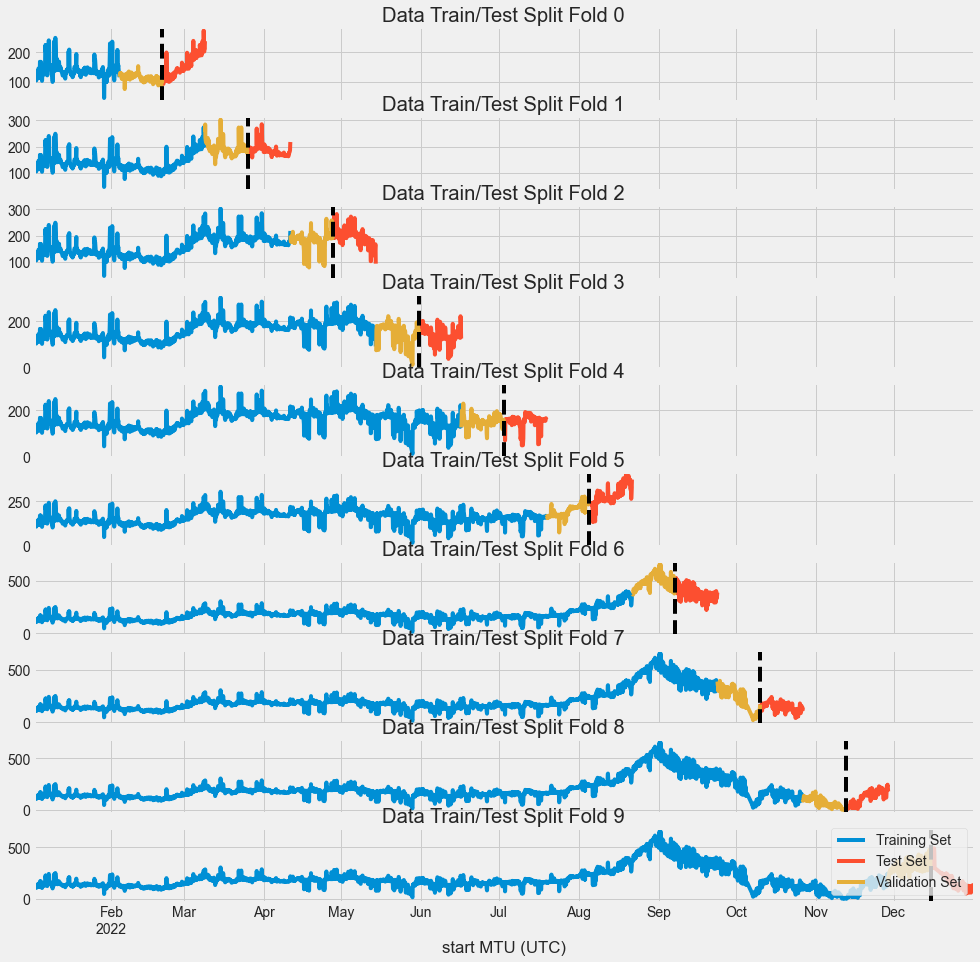

In [562]:
# use a 5-fold cross-validation with each fold representing a period of approximately 73 days.
times_series = TimeSeriesSplit(n_splits=10, gap=0)

fig, axs = plt.subplots(10, 1, figsize=(15, 15), sharex=True)

fold = 0
preds = []
scores = []
for train_idx, val_idx in times_series.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    val_data, test = train_test_split(test, test_size=0.5, shuffle=False)

    # Train dataset
    X_train = train[FEATURES]
    y_train = train[TARGET]

    ## Test dataset, used for predicting
    X_test = test[FEATURES]
    y_test = test[TARGET]

    # used for eval_set()
    X_valid= val_data[FEATURES]
    y_valid = val_data[TARGET]

    default_reg = xgb.XGBRegressor (
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        nthread=4,
        scale_pos_weight=1,
        seed=27)

    ## Fit the model using train data and do simple evaluation using validation set
    default_reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=100)

    ### Forecast using the test data
    y_pred = default_reg.predict(X_test)
    preds.append(y_pred)

    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    train[TARGET].plot(ax=axs[fold],
                        label='Training Set')

    test[TARGET].plot(ax=axs[fold],
                        label='Test Set')

    val_data[TARGET].plot(ax=axs[fold],
                        label='Validation Set',
                        title=f'Data Train/Test Split Fold {fold}')

    axs[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1


plt.legend(loc="best")
plt.show()

In [563]:
print("Train set :", train.shape, ". Which is almost 305 days from 365 days")
print("Test set :", test.shape, ". Which is almost 30 days from 365 days")
print("Test set :", val_data.shape, ". Which is almost 30 days from 365 days")

Train set : (7943, 820) . Which is almost 305 days from 365 days
Test set : (397, 820) . Which is almost 30 days from 365 days
Test set : (397, 820) . Which is almost 30 days from 365 days


In [564]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 72.3949
Fold scores:[28.804972418266484, 35.35804011474473, 29.244499279840312, 23.595561148650543, 45.570398085151275, 128.89617890809365, 232.7482503618893, 70.39486714264945, 65.94198020176066, 63.39398270919555]


### Testing lagged_features for a limited time frame

In [565]:
df_limited = df.loc[ '2022-12-29' : '2022-12-31']
df.index

DatetimeIndex(['2022-01-01 23:00:00', '2022-01-02 00:00:00',
               '2022-01-02 01:00:00', '2022-01-02 02:00:00',
               '2022-01-02 03:00:00', '2022-01-02 04:00:00',
               '2022-01-02 05:00:00', '2022-01-02 06:00:00',
               '2022-01-02 07:00:00', '2022-01-02 08:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', name='start MTU (UTC)', length=8737, freq=None)

In [566]:
# Function to create lagged dataset wit 24 lag features for each input feature
def create_lagged_dataset(df):
    # creating a copy of the dataframe
    lagged_df = df.copy()

    # Adding lagged features for target variable
    lagged_df['Day-ahead Price _EUR/MWh_ BZN|NO1'] = lagged_df['Day-ahead Price _EUR/MWh_ BZN|NO1'].shift(-1)

    # Dropping the last row containing NaN values
    lagged_df.dropna(inplace=True)

    # Creating a dataframe with lagged features with 24 steps for each of the original features
    lagged_df = pd.concat([lagged_df.shift(i) for i in range(25)], axis=1)

    # Removing the NaN rows that have been created in the beginning of the dataset
    lagged_df.dropna(inplace=True)

    return lagged_df

# 4. Training Model


We have to remove all symbols from feature names , otherwise get the following error :

"  ValueError: feature_names must be string, and may not contain [, ] or <  "


### Simple regressor and parameters

In [567]:
"""
## (0.10812,3.69 )
basic_reg = xgb.XGBRegressor (
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=4,
    scale_pos_weight=1,
    seed=27)

### (0.08, 3,23) second , best
 = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=1000,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.01)
"""

"\n## (0.10812,3.69 )\nbasic_reg = xgb.XGBRegressor (\n    learning_rate =0.1,\n    n_estimators=1000,\n    max_depth=5,\n    min_child_weight=1,\n    gamma=0,\n    subsample=0.8,\n    colsample_bytree=0.8,\n    nthread=4,\n    scale_pos_weight=1,\n    seed=27)\n\n### (0.08, 3,23) second , best\n = xgb.XGBRegressor(\n    base_score=0.5,\n    booster='gbtree',\n    n_estimators=1000,\n    early_stopping_rounds=50,\n    objective='reg:squarederror',\n    max_depth=3,\n    learning_rate=0.01)\n"

In [568]:
# start timer
start_time = time.time()
end_time = time.time()
#print the run time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

Runtime: 0.00 seconds


## Feature Importance


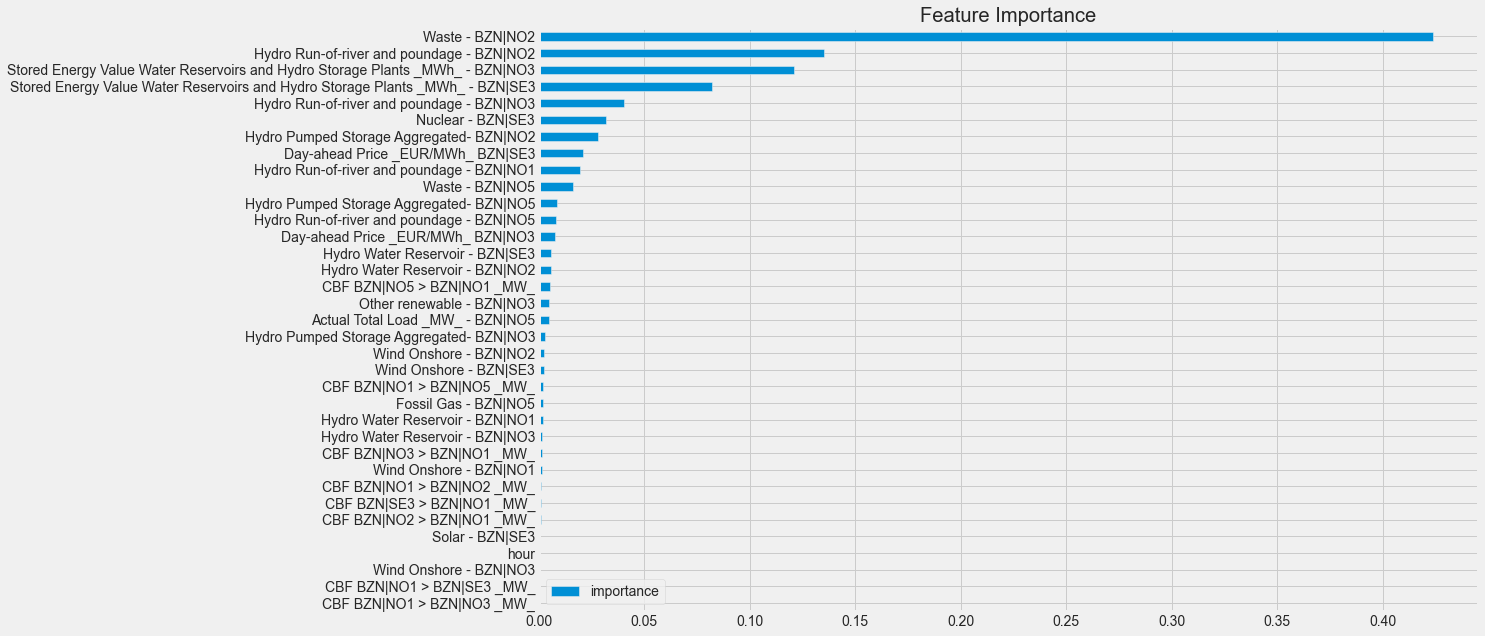

In [569]:
fi = pd.DataFrame(data=default_reg.feature_importances_,
             index=default_reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize= (15,10))
plt.show()

# Forecast on validation data


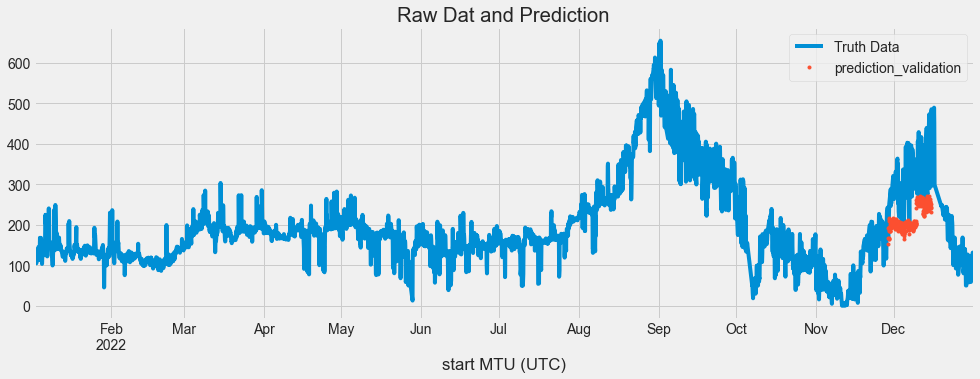

In [570]:
val_data['prediction_validation'] = default_reg.predict(X_valid)
df = df.merge(val_data[['prediction_validation']], how='left', left_index=True, right_index=True)
ax = df[['Day-ahead Price _EUR/MWh_ BZN|NO1']].plot(figsize=(15, 5))
df['prediction_validation'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction_validation'])
ax.set_title('Raw Dat and Prediction')
plt.show()

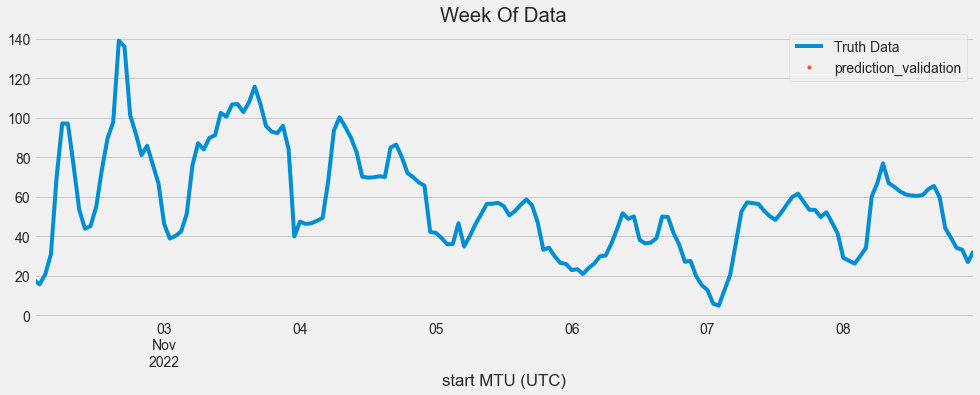

In [571]:
ax = df.loc[(df.index > '2022-11-02') & (df.index < '2022-11-09')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2022-11-02') & (df.index < '2022-11-09')]['prediction_validation'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_validation'])
plt.show()


### Score on validation data

In [572]:
score = np.sqrt(mean_squared_error(val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], val_data['prediction_validation']))
print(f'RMSE Score on valid set: {score:0.2f}')


# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], val_data['prediction_validation'])
print("Mean absolute error:            ", mae)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], val_data['prediction_validation'])
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Rood mean squared error:        ", rmse)

RMSE Score on valid set: 111.01
Mean absolute error:             98.27338893169718
Mean squared error:              12323.294369707604
Rood mean squared error:         111.01033451759167


In [573]:
response_range = val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'].max() - val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'].min()

# Determine if the RMSE value is a good fit
if rmse < 0.1 * response_range:
    print("The RMSE value of", rmse, "is a good fit for this time series regression model. When the response range is :", response_range)
else:
    print("The RMSE value of", rmse, "indicates poor performance for this time series regression model. When the response range is :", response_range)


The RMSE value of 111.01033451759167 indicates poor performance for this time series regression model. When the response range is : 306.7


In [574]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [575]:
mean_absolute_percentage_error(y_true=val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'],
                               y_pred=val_data['prediction_validation'])

29.71386230936814

# Forecast on Test data

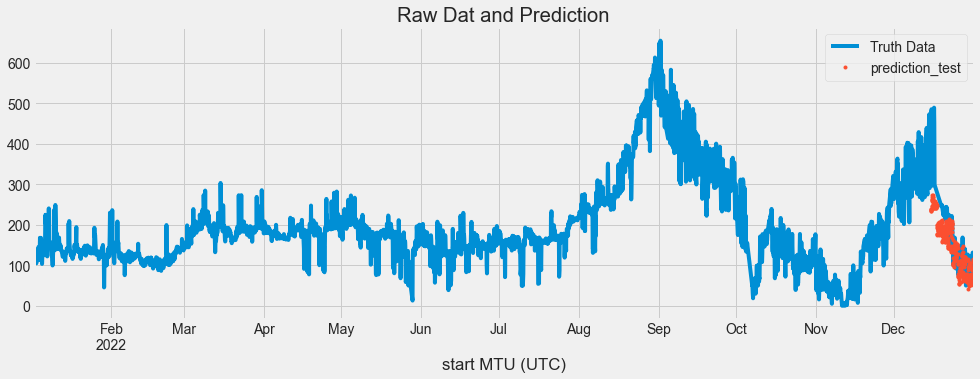

In [576]:
test['prediction_test'] = default_reg.predict(X_test)
df = df.merge(test[['prediction_test']], how='left', left_index=True, right_index=True)
ax = df[['Day-ahead Price _EUR/MWh_ BZN|NO1']].plot(figsize=(15, 5))
df['prediction_test'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction_test'])
ax.set_title('Raw Dat and Prediction')
plt.show()

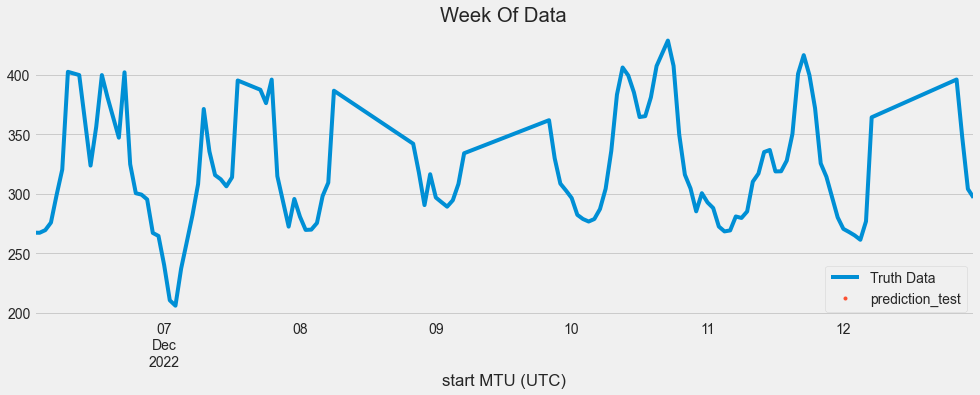

In [577]:
## Showing predicted test data on a week
ax = df.loc[(df.index > '2022-12-06') & (df.index < '2022-12-13')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2022-12-06') & (df.index < '2022-12-13')]['prediction_test'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_test'])
plt.show()


# Score (RMSE)

### Score on test

In [578]:
score = np.sqrt(mean_squared_error(test['Day-ahead Price _EUR/MWh_ BZN|NO1'], test['prediction_test']))
print(f'RMSE Score on valid set: {score:0.2f}')


# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(test['Day-ahead Price _EUR/MWh_ BZN|NO1'], test['prediction_test'])
print("Mean absolute error:            ", mae)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(test['Day-ahead Price _EUR/MWh_ BZN|NO1'], test['prediction_test'])
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Rood mean squared error:        ", rmse)

RMSE Score on valid set: 63.39
Mean absolute error:             43.02143531472617
Mean squared error:              4018.7970437337844
Rood mean squared error:         63.39398270919555


In [579]:
mean_absolute_percentage_error(y_true=test['Day-ahead Price _EUR/MWh_ BZN|NO1'],
                               y_pred=test['prediction_test'])

20.59630438367785

# Calculate Error
- Look at the worst and best predicted days


In [580]:
test['error'] = np.abs(test[TARGET] - test['prediction_test'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-12-15    160.945232
2022-12-16    142.696197
2022-12-18     75.118246
2022-12-17     55.226142
2022-12-19     54.514610
2022-12-20     47.735899
2022-12-21     39.664202
2022-12-26     33.847777
2022-12-31     31.271762
2022-12-29     28.724485
Name: error, dtype: float64

# 5. Predicting 24 hours time horizon